In [2]:
import pandas as pd
from transformers import RobertaTokenizer, AutoTokenizer, BertTokenizer, AutoModelForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
import unicodedata
import re
from bs4 import BeautifulSoup
import torch
import torch.nn.functional as F

c:\Users\User\Documents\Code\bot-judol\engine\env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [16]:
df = pd.read_csv("scraping/clean/data_judol.csv")
df.head()

,label,username,video_id,comment
0,NaN,@2NineFitIndonesia,QhmebdBeXKY,Kebanyakan Orang tua di Indonesia masih percay...
1,NaN,@azkamaulana6736,QhmebdBeXKY,Bang saya mau nanya saya sebenarnya sudah WO 1...
2,NaN,@Arwindarx,QhmebdBeXKY,👌🏽
3,NaN,@jauharsyarif6582,QhmebdBeXKY,Dari umur berapa yah baiknya anak mulai latiha...
4,NaN,@XyieroAldi1445,QhmebdBeXKY,Orang indo kebanyakan mitos😂


In [ ]:
# Mapping untuk mengganti karakter mirip huruf/angka (visual clones)
CHARACTER_MAP = {
    # Unicode fancy to normal
    '𝐀': 'A', '𝐁': 'B', '𝐂': 'C', '𝐃': 'D', '𝐄': 'E', '𝐅': 'F', '𝐆': 'G',
    '𝐇': 'H', '𝐈': 'I', '𝐉': 'J', '𝐊': 'K', '𝐋': 'L', '𝐌': 'M', '𝐍': 'N',
    '𝐎': 'O', '𝐏': 'P', '𝐐': 'Q', '𝐑': 'R', '𝐒': 'S', '𝐓': 'T', '𝐔': 'U',
    '𝐕': 'V', '𝐖': 'W', '𝐗': 'X', '𝐘': 'Y', '𝐙': 'Z',
    '𝐚': 'a', '𝐛': 'b', '𝐜': 'c', '𝐝': 'd', '𝐞': 'e', '𝐟': 'f', '𝐠': 'g',
    '𝐡': 'h', '𝐢': 'i', '𝐣': 'j', '𝐤': 'k', '𝐥': 'l', '𝐦': 'm', '𝐧': 'n',
    '𝐨': 'o', '𝐩': 'p', '𝐪': 'q', '𝐫': 'r', '𝐬': 's', '𝐭': 't', '𝐮': 'u',
    '𝐯': 'v', '𝐰': 'w', '𝐱': 'x', '𝐲': 'y', '𝐳': 'z',
    
    # Gothic/Fraktur
    '𝔄': 'A', '𝔅': 'B', 'ℭ': 'C', '𝔇': 'D', '𝔈': 'E', '𝔉': 'F', '𝔊': 'G',
    '𝔍': 'J', '𝔎': 'K', '𝔏': 'L', '𝔐': 'M', '𝔑': 'N', '𝔒': 'O', '𝔓': 'P',
    '𝔔': 'Q', 'ℜ': 'R', '𝔖': 'S', '𝔗': 'T', '𝔘': 'U', '𝔙': 'V', '𝔚': 'W',
    '𝔛': 'X', '𝔜': 'Y', '𝔞': 'a', '𝔟': 'b', '𝔠': 'c', '𝔡': 'd',
    '𝔢': 'e', '𝔣': 'f', '𝔤': 'g', '𝔥': 'h', '𝔦': 'i', '𝔧': 'j',
    '𝔨': 'k', '𝔩': 'l', '𝔪': 'm', '𝔫': 'n', '𝔬': 'o', '𝔭': 'p',
    '𝔮': 'q', '𝔯': 'r', '𝔰': 's', '𝔱': 't', '𝔲': 'u', '𝔳': 'v',
    '𝔴': 'w', '𝔵': 'x', '𝔶': 'y', '𝔷': 'z',

    # Emoji angka ke angka
    '0️⃣': '0', '1️⃣': '1', '2️⃣': '2', '3️⃣': '3', '4️⃣': '4',
    '5️⃣': '5', '6️⃣': '6', '7️⃣': '7', '8️⃣': '8', '9️⃣': '9',

    # Unicode angka gaya
    '𝟎': '0', '𝟏': '1', '𝟐': '2', '𝟑': '3', '𝟒': '4',
    '𝟓': '5', '𝟔': '6', '𝟕': '7', '𝟖': '8', '𝟗': '9',

    # Bulatan/simbol angka
    '❶': '1', '❷': '2', '❸': '3', '❹': '4', '❺': '5',
    '❻': '6', '❼': '7', '❽': '8', '❾': '9', '❿': '10',
    
    # Simbol huruf
    'ⓐ': 'a', 'ⓑ': 'b', 'ⓒ': 'c', 'ⓓ': 'd', 'ⓔ': 'e', 'ⓕ': 'f', 'ⓖ': 'g',
    'ⓗ': 'h', 'ⓘ': 'i', 'ⓙ': 'j', 'ⓚ': 'k', 'ⓛ': 'l', 'ⓜ': 'm', 'ⓝ': 'n',
    'ⓞ': 'o', 'ⓟ': 'p', 'ⓠ': 'q', 'ⓡ': 'r', 'ⓢ': 's', 'ⓣ': 't', 'ⓤ': 'u',
    'ⓥ': 'v', 'ⓦ': 'w', 'ⓧ': 'x', 'ⓨ': 'y', 'ⓩ': 'z',
    
    # Simbol aneh
    'ᗪ': 'D', 'ᗩ': 'A', 'ᒪ': 'L', 'ᑭ': 'P', 'ᖇ': 'R', 'ᗷ': 'B', 'ᑕ': 'C', 'ᗷ': 'B',

    '🅰️': 'A', '🅱️': 'B', '🅾️': 'O', '🆎': 'AB', '🆑': 'CL', '🆒': 'COOL',
    '🆓': 'FREE', '🆔': 'ID', '🆕': 'NEW', '🆖': 'NG', '🆗': 'OK',
    '🆘': 'SOS', '🆙': 'UP', '🆚': 'VS',

    # Full A-Z boxed (manually added)
    '🅿️': 'P', '🆀': 'Q', '🆁': 'R', '🆂': 'S', '🆃': 'T',
    '🆄': 'U', '🆅': 'V', '🆆': 'W', '🆇': 'X', '🆈': 'Y', '🆉': 'Z',
    '🅰': 'A', '🅱': 'B', '🅾': 'O', '🅿': 'P',

    # Emoji 0-9 (opsional untuk konsistensi)
    '0️⃣': '0', '1️⃣': '1', '2️⃣': '2', '3️⃣': '3', '4️⃣': '4',
    '5️⃣': '5', '6️⃣': '6', '7️⃣': '7', '8️⃣': '8', '9️⃣': '9',

    '🅰': 'A', '🅱': 'B', '🅲': 'C', '🅳': 'D', '🅴': 'E', '🅵': 'F',
    '🅶': 'G', '🅷': 'H', '🅸': 'I', '🅹': 'J', '🅺': 'K', '🅻': 'L',
    '🅼': 'M', '🅽': 'N', '🅾': 'O', '🅿': 'P', '🆀': 'Q', '🆁': 'R',
    '🆂': 'S', '🆃': 'T', '🆄': 'U', '🆅': 'V', '🆆': 'W', '🆇': 'X',
    '🆈': 'Y', '🆉': 'Z',
    # Dengan VS16 (versi dengan emoji modifier) juga
    '🅰️': 'A', '🅱️': 'B', '🅾️': 'O', '🅿️': 'P', '🆄️': 'U', '🅻️': 'L', '🆆️': 'W',
    '🅸️': 'I', '🅽️': 'N', '🆃️': 'T', '🆂️': 'S', '🆅️': 'V', '🆇️': 'X', '🆈️': 'Y', '🆉️': 'Z',

    '🅐': 'A', '🅑': 'B', '🅒': 'C', '🅓': 'D', '🅔': 'E', '🅕': 'F',
    '🅖': 'G', '🅗': 'H', '🅘': 'I', '🅙': 'J', '🅚': 'K', '🅛': 'L',
    '🅜': 'M', '🅝': 'N', '🅞': 'O', '🅟': 'P', '🅠': 'Q', '🅡': 'R',
    '🅢': 'S', '🅣': 'T', '🅤': 'U', '🅥': 'V', '🅦': 'W', '🅧': 'X',
    '🅨': 'Y', '🅩': 'Z',

    # Enclosed numbers (circled)
    '①': '1', '②': '2', '③': '3', '④': '4', '⑤': '5',
    '⑥': '6', '⑦': '7', '⑧': '8', '⑨': '9', '⑩': '10',
    '⑪': '11', '⑫': '12', '⑬': '13', '⑭': '14', '⑮': '15',
    '⑯': '16', '⑰': '17', '⑱': '18', '⑲': '19', '⑳': '20',
    '⓪': '0',

    # Fullwidth digits
    '０': '0', '１': '1', '２': '2', '３': '3', '４': '4',
    '５': '5', '６': '6', '７': '7', '８': '8', '９': '9',

    # Fullwidth A-Z
    'Ａ': 'A', 'Ｂ': 'B', 'Ｃ': 'C', 'Ｄ': 'D', 'Ｅ': 'E', 'Ｆ': 'F',
    'Ｇ': 'G', 'Ｈ': 'H', 'Ｉ': 'I', 'Ｊ': 'J', 'Ｋ': 'K', 'Ｌ': 'L',
    'Ｍ': 'M', 'Ｎ': 'N', 'Ｏ': 'O', 'Ｐ': 'P', 'Ｑ': 'Q', 'Ｒ': 'R',
    'Ｓ': 'S', 'Ｔ': 'T', 'Ｕ': 'U', 'Ｖ': 'V', 'Ｗ': 'W', 'Ｘ': 'X',
    'Ｙ': 'Y', 'Ｚ': 'Z',

    # Fullwidth a-z
    'ａ': 'a', 'ｂ': 'b', 'ｃ': 'c', 'ｄ': 'd', 'ｅ': 'e', 'ｆ': 'f',
    'ｇ': 'g', 'ｈ': 'h', 'ｉ': 'i', 'ｊ': 'j', 'ｋ': 'k', 'ｌ': 'l',
    'ｍ': 'm', 'ｎ': 'n', 'ｏ': 'o', 'ｐ': 'p', 'ｑ': 'q', 'ｒ': 'r',
    'ｓ': 's', 'ｔ': 't', 'ｕ': 'u', 'ｖ': 'v', 'ｗ': 'w', 'ｘ': 'x',
    'ｙ': 'y', 'ｚ': 'z',

    # Fancy bold letters a-z (𝐚 – 𝐳)
    '𝐚': 'a', '𝐛': 'b', '𝐜': 'c', '𝐝': 'd', '𝐞': 'e', '𝐟': 'f',
    '𝐠': 'g', '𝐡': 'h', '𝐢': 'i', '𝐣': 'j', '𝐤': 'k', '𝐥': 'l',
    '𝐦': 'm', '𝐧': 'n', '𝐨': 'o', '𝐩': 'p', '𝐪': 'q', '𝐫': 'r',
    '𝐬': 's', '𝐭': 't', '𝐮': 'u', '𝐯': 'v', '𝐰': 'w', '𝐱': 'x',
    '𝐲': 'y', '𝐳': 'z',

    # Math double-struck (𝔸 – 𝕫)
    '𝔸': 'A', '𝔹': 'B', 'ℂ': 'C', '𝔻': 'D', '𝔼': 'E', '𝔽': 'F',
    '𝔾': 'G', 'ℍ': 'H', '𝕀': 'I', '𝕁': 'J', '𝕂': 'K', '𝕃': 'L',
    '𝕄': 'M', 'ℕ': 'N', '𝕆': 'O', 'ℙ': 'P', 'ℚ': 'Q', 'ℝ': 'R',
    '𝕊': 'S', '𝕋': 'T', '𝕌': 'U', '𝕍': 'V', '𝕎': 'W', '𝕏': 'X',
    '𝕐': 'Y', 'ℤ': 'Z',

    '𝕒': 'a', '𝕓': 'b', '𝕔': 'c', '𝕕': 'd', '𝕖': 'e', '𝕗': 'f',
    '𝕘': 'g', '𝕙': 'h', '𝕚': 'i', '𝕛': 'j', '𝕜': 'k', '𝕝': 'l',
    '𝕞': 'm', '𝕟': 'n', '𝕠': 'o', '𝕡': 'p', '𝕢': 'q', '𝕣': 'r',
    '𝕤': 's', '𝕥': 't', '𝕦': 'u', '𝕧': 'v', '𝕨': 'w', '𝕩': 'x',
    '𝕪': 'y', '𝕫': 'z',

    # Mathematical italic and script variants
    '𝒜': 'A', '𝒞': 'C', '𝒟': 'D', '𝒢': 'G', '𝒥': 'J', '𝒦': 'K',
    '𝒩': 'N', '𝒪': 'O', '𝒫': 'P', '𝒬': 'Q', '𝒮': 'S', '𝒯': 'T',
    '𝒰': 'U', '𝒱': 'V', '𝒲': 'W', '𝒳': 'X', '𝒴': 'Y', '𝒵': 'Z',
    '𝒶': 'a', '𝒷': 'b', '𝒸': 'c', '𝒹': 'd', '𝑒': 'e', '𝒻': 'f',
    '𝑔': 'g', '𝒽': 'h', '𝒾': 'i', '𝒿': 'j', '𝓀': 'k', '𝓁': 'l',
    '𝓂': 'm', '𝓃': 'n', '𝑜': 'o', '𝓅': 'p', '𝓆': 'q', '𝓇': 'r',
    '𝓈': 's', '𝓉': 't', '𝓊': 'u', '𝓋': 'v', '𝓌': 'w', '𝓍': 'x',
    '𝓎': 'y', '𝓏': 'z',

    # Superscript & Subscript Numbers
    '⁰': '0', '¹': '1', '²': '2', '³': '3',
    '⁴': '4', '⁵': '5', '⁶': '6', '⁷': '7', '⁸': '8', '⁹': '9',

    '₀': '0', '₁': '1', '₂': '2', '₃': '3',
    '₄': '4', '₅': '5', '₆': '6', '₇': '7', '₈': '8', '₉': '9',

    # Greek Lookalikes
    'Α': 'A', 'Β': 'B', 'Ε': 'E', 'Ζ': 'Z', 'Η': 'H',
    'Ι': 'I', 'Κ': 'K', 'Μ': 'M', 'Ν': 'N', 'Ο': 'O',
    'Ρ': 'P', 'Τ': 'T', 'Υ': 'Y', 'Χ': 'X',

    # Roman Numerals
    'Ⅰ': '1', 'Ⅱ': '2', 'Ⅲ': '3', 'Ⅳ': '4', 'Ⅴ': '5',
    'Ⅵ': '6', 'Ⅶ': '7', 'Ⅷ': '8', 'Ⅸ': '9', 'Ⅹ': '10',

    # Braille Patterns
    '⠁': 'A', '⠃': 'B', '⠉': 'C', '⠙': 'D', '⠑': 'E', '⠋': 'F',
    '⠛': 'G', '⠓': 'H', '⠊': 'I', '⠚': 'J', '⠅': 'K', '⠇': 'L',
    '⠍': 'M', '⠝': 'N', '⠕': 'O', '⠏': 'P', '⠟': 'Q', '⠗': 'R',
    '⠎': 'S', '⠞': 'T', '⠥': 'U', '⠧': 'V', '⠺': 'W', '⠭': 'X',
    '⠽': 'Y', '⠵': 'Z',

    # Regional Indicator Symbols
    '🇦': 'A', '🇧': 'B', '🇨': 'C', '🇩': 'D', '🇪': 'E',
    '🇫': 'F', '🇬': 'G', '🇭': 'H', '🇮': 'I', '🇯': 'J',
    '🇰': 'K', '🇱': 'L', '🇲': 'M', '🇳': 'N', '🇴': 'O',
    '🇵': 'P', '🇶': 'Q', '🇷': 'R', '🇸': 'S', '🇹': 'T',
    '🇺': 'U', '🇻': 'V', '🇼': 'W', '🇽': 'X', '🇾': 'Y',
    '🇿': 'Z',

    # Small Caps Unicode
    'ᴀ': 'a', 'ʙ': 'b', 'ᴄ': 'c', 'ᴅ': 'd', 'ᴇ': 'e', 'ғ': 'f',
    'ɢ': 'g', 'ʜ': 'h', 'ɪ': 'i', 'ᴊ': 'j', 'ᴋ': 'k', 'ʟ': 'l',
    'ᴍ': 'm', 'ɴ': 'n', 'ᴏ': 'o', 'ᴘ': 'p', 'ǫ': 'q', 'ʀ': 'r',
    's': 's', 'ᴛ': 't', 'ᴜ': 'u', 'ᴠ': 'v', 'ᴡ': 'w', 'x': 'x',
    'ʏ': 'y', 'ᴢ': 'z', 'Ø': 'O',

    # Greek
    'Α': 'A',  # Alpha
    'Β': 'B',  # Beta
    'Ε': 'E',  # Epsilon
    'Ζ': 'Z',  # Zeta
    'Η': 'H',  # Eta
    'Ι': 'I',  # Iota
    'Κ': 'K',  # Kappa
    'Μ': 'M',  # Mu
    'Ν': 'N',  # Nu
    'Ο': 'O',  # Omicron
    'Ρ': 'P',  # Rho
    'Τ': 'T',  # Tau
    'Υ': 'Y',  # Upsilon
    'Χ': 'X',  # Chi
    'Λ': 'A',  # Lambda (🔴 kasus kamu)
    'Δ': 'A',  # Delta (opsional)

    # Cyrillic (Russian lookalikes)
    'а': 'a', 'е': 'e', 'о': 'o', 'р': 'p', 'с': 'c', 'х': 'x',
    'А': 'A', 'В': 'B', 'Е': 'E', 'К': 'K', 'М': 'M', 'Н': 'H',
    'О': 'O', 'Р': 'P', 'С': 'C', 'Т': 'T', 'Х': 'X',

    # 
    'ℬ': 'B', 'ℰ': 'E', 'ℱ': 'F', 'ℋ': 'H', 'ℐ': 'I', 'ℒ': 'L',
    'ℳ': 'M', 'ℛ': 'R', 'ᗯ': 'W',  # Looks like capital W
    'ᗷ': 'B',  # Looks like capital B
    'ᗩ': 'A',
    'ᒪ': 'L',
    'ᑎ': 'N',
    'ᑌ': 'U',
    'ᗰ': 'M',
    'ᑭ': 'P',
    'ᑫ': 'Q',

    # 
    'в': 'b', 'є': 'e', 'т': 't',
    # Greek
    'ρ': 'p', 'σ': 'o', 'η': 'n',

    # Cyrillic & Greek lookalike Latin
    'Α': 'A', 'А': 'A', 'Β': 'B', 'В': 'B', 'С': 'C', 'Е': 'E', 'Ε': 'E',
    'Η': 'H', 'Н': 'H', 'Ι': 'I', 'І': 'I', 'Ј': 'J', 'Κ': 'K', 'К': 'K',
    'Μ': 'M', 'М': 'M', 'Ν': 'N', 'О': 'O', 'Ο': 'O', 'Ρ': 'P', 'Р': 'P',
    'Ѕ': 'S', 'Τ': 'T', 'Т': 'T', 'Χ': 'X', 'Х': 'X', 'Υ': 'Y', 'Ү': 'Y',
    'а': 'a', 'с': 'c', 'е': 'e', 'є': 'e', 'ҽ': 'e', 'ɡ': 'g', 'һ': 'h',
    'і': 'i', 'ӏ': 'i', '¡': 'i', 'ј': 'j', 'ο': 'o', 'о': 'o', 'ө': 'o',
    'п': 'n', 'η': 'n', 'ρ': 'p', 'р': 'p', 'ѕ': 's', 'т': 't', 'ѵ': 'v',
    'ν': 'v', 'в': 'b', 'х': 'x', 'χ': 'x', 'у': 'y', 'ү': 'y',

    # Visual digit clones
    '〇': '0', 'З': '3', 'Ƽ': '5', '߈': '4'
}

def strip_urls_and_timestamps(text: str) -> str:
    # Hapus URL penuh (http, https, www)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)

    # Hapus URL shortener umum seperti bit.ly, t.co, dll.
    text = re.sub(r'\b(bit\.ly|tinyurl\.com|t\.co|goo\.gl|linktr\.ee)/\S+', '', text)

    # Hapus timestamp video dalam format 00:12 atau 1:02:03
    text = re.sub(r'\b\d{1,2}:\d{2}(?::\d{2})?\b', '', text)

    return text

def strip_html_tags(text: str) -> str:
    # Hapus seluruh tag HTML dan ambil teksnya saja
    return BeautifulSoup(text, "html.parser").get_text()

def strip_symbols_prefix(text: str) -> str:
    # Ubah @mention dan #hashtag menjadi kata biasa tanpa simbolnya
    return re.sub(r'[@#](\w+)', r'\1', text)

# Fungsi utama normalisasi teks
def normalize_text(text: str) -> str:
    # Hapus tag HTML
    text = strip_html_tags(text)

    # Hapus URL, shortener, dan timestamp
    text = strip_urls_and_timestamps(text)

    # Hapus simbol @ dan # di awal kata (biarkan katanya tetap ada)
    text = strip_symbols_prefix(text)

    # Ganti karakter spesial berdasarkan peta karakter
    text = ''.join(CHARACTER_MAP.get(char, char) for char in text)

    # Normalisasi Unicode dan hapus karakter combining (misalnya aksen atau garis bawah panjang)
    text = unicodedata.normalize('NFKD', text)
    text = ''.join([c for c in text if not unicodedata.combining(c)])

    # Hapus karakter zero-width/invisible seperti ZWJ dan ZWNJ
    text = re.sub(r'[\u200B\u200C\u200D\uFEFF]', '', text)

    # Hapus simbol/emoji non-informasi, hanya pertahankan huruf, angka, spasi, dan dash
    text = re.sub(r'[^\w\s\-]', ' ', text)

    # Ubah ke huruf kecil dan hapus spasi di awal/akhir
    return text.lower().strip()

In [35]:
df['clean_comment'] = df['comment'].apply(normalize_text)
df['clean_comment'] = df['username'].fillna('').astype(str) + ' ' + df['clean_comment']

In [37]:
df.head()

,label,username,video_id,comment,clean_comment
0,NaN,@2NineFitIndonesia,QhmebdBeXKY,Kebanyakan Orang tua di Indonesia masih percay...,@2NineFitIndonesia kebanyakan orang tua di ind...
1,NaN,@azkamaulana6736,QhmebdBeXKY,Bang saya mau nanya saya sebenarnya sudah WO 1...,@azkamaulana6736 bang saya mau nanya saya sebe...
2,NaN,@Arwindarx,QhmebdBeXKY,👌🏽,@Arwindarx
3,NaN,@jauharsyarif6582,QhmebdBeXKY,Dari umur berapa yah baiknya anak mulai latiha...,@jauharsyarif6582 dari umur berapa yah baiknya...
4,NaN,@XyieroAldi1445,QhmebdBeXKY,Orang indo kebanyakan mitos😂,@XyieroAldi1445 orang indo kebanyakan mitos


In [48]:
print("Jumlah data setelah dibersihkan:")
print(f"- Total: {len(df)}")
print("jumlah data string kosong")
print(df[df['clean_comment'] == ""]['clean_comment'].count())
print("jumlah data duplikat")
print(df[df['clean_comment'].duplicated()]['clean_comment'].count())

Jumlah data setelah dibersihkan:
- Total: 15571
jumlah data string kosong
0
jumlah data duplikat
1120


In [45]:
df_clean = df[df['clean_comment'].str.strip() != ""]
df_clean = df_clean.drop_duplicates(subset=['clean_comment'], keep='first')
df_clean = df_clean.reset_index(drop=True)

In [46]:
print("Jumlah data setelah dibersihkan:")
print(f"- Total: {len(df_clean)}")
print(f"- Kosong: {df_clean[df_clean['clean_comment'].str.strip() == '']['clean_comment'].count()}")
print(f"- Duplikat: {df_clean.duplicated(subset=['clean_comment']).sum()}")

Jumlah data setelah dibersihkan:
- Total: 14450
- Kosong: 0
- Duplikat: 0


In [49]:
df_clean.to_csv("scraping/clean/data_judol_clean.csv", index=False)

## Concat Labeled Data

In [14]:
import pandas as pd

df1 = pd.read_csv("scraping/clean/data_judol_clean_1.csv")
df2 = pd.read_csv("scraping/clean/data_judol_clean_2.csv")
df_clean = pd.concat([df1, df2])
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14450 entries, 0 to 1471
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   label          14450 non-null  object
 1   username       10163 non-null  object
 2   video_id       948 non-null    object
 3   comment        14450 non-null  object
 4   clean_comment  14450 non-null  object
dtypes: object(5)
memory usage: 677.3+ KB


In [15]:
df_clean.to_csv("scraping/clean/data_judol_cleanest.csv", index=False)

## Balanced Data

In [24]:
df1 = pd.read_csv("scraping/clean/data_judol_clean_1.csv")
df2 = pd.read_csv("scraping/clean/data_judol_clean_2.csv")
df_balance = pd.concat([df2, df1])
df_balance.head()

,label,username,video_id,comment,clean_comment
0,1.0,NaN,NaN,Rezeki dari 𝘈𝐺𝑈S𝐓𝐎𝘛О-bikin senyum lebar hari i...,rezeki dari agustoto-bikin senyum lebar hari ...
1,1.0,NaN,NaN,Pecah banget di 𝘈𝐺𝑈S𝐓𝐎𝘛О,pecah banget di agustoto
2,1.0,NaN,NaN,"𝘈𝐺𝑈S𝐓𝐎𝘛О ini beda sih, gacornya kebangetan bik...",agustoto ini beda sih gacornya kebangetan bi...
3,1.0,NaN,NaN,𝘈𝐺𝑈S𝐓𝐎𝘛Оmenyediakan ruang untuk kolaborasi dan...,agustotomenyediakan ruang untuk kolaborasi da...
4,1.0,NaN,NaN,Begitu mantap dan memuaskan! Bermain di 𝘈𝐺𝑈S𝐓𝐎...,begitu mantap dan memuaskan bermain di agust...


In [25]:
df_balance['label_category'] = df_balance['label'] >= 0.5
df_balance['label_category'].value_counts()

label_category
False    11363
True      3087
Name: count, dtype: int64

In [29]:
# balance data
df_false = df_balance[df_balance['label_category'] == False].reset_index(drop=True)
df_false = df_false[:3100]
df_false.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3100 entries, 0 to 3099
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           3100 non-null   float64
 1   username        1269 non-null   object 
 2   video_id        329 non-null    object 
 3   comment         3100 non-null   object 
 4   clean_comment   3100 non-null   object 
 5   label_category  3100 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 124.2+ KB


In [30]:
df_true = df_balance[df_balance['label_category'] == True].reset_index(drop=True)
df_true.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3087 entries, 0 to 3086
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           3087 non-null   float64
 1   username        1525 non-null   object 
 2   video_id        619 non-null    object 
 3   comment         3087 non-null   object 
 4   clean_comment   3087 non-null   object 
 5   label_category  3087 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 123.7+ KB


In [31]:
df_last = pd.concat([df_true, df_false])
df_last.reset_index(inplace=True, drop=True)
df_last.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6187 entries, 0 to 6186
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   label           6187 non-null   float64
 1   username        2794 non-null   object 
 2   video_id        948 non-null    object 
 3   comment         6187 non-null   object 
 4   clean_comment   6187 non-null   object 
 5   label_category  6187 non-null   bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 247.8+ KB


In [32]:
df_last['label_category'].value_counts()

label_category
False    3100
True     3087
Name: count, dtype: int64

In [33]:
df_last.to_csv("scraping/clean/data_judol_balanced.csv", index=False)

## Data Analysis

In [7]:
df = pd.read_csv("scraping/clean/data_judol_balanced.csv")
df = df.sample(frac=1)
df['label'] = df['label'].astype(int)
df.reset_index(inplace=True, drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6187 entries, 0 to 6186
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   label           6187 non-null   int64 
 1   username        2794 non-null   object
 2   video_id        948 non-null    object
 3   comment         6187 non-null   object
 4   clean_comment   6187 non-null   object
 5   label_category  6187 non-null   bool  
dtypes: bool(1), int64(1), object(4)
memory usage: 247.8+ KB


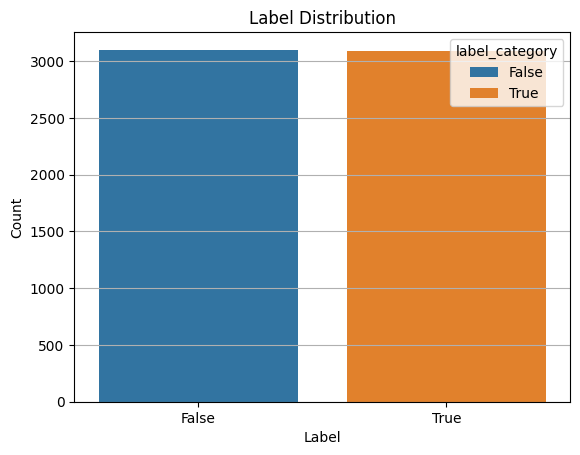

In [8]:
sns.countplot(x='label_category', data=df, hue='label_category')
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.grid(axis='y')
plt.show()

In [ ]:
# number of token in the comment data
tokenizer = RobertaTokenizer.from_pretrained("distilbert/distilroberta-base")

def count_token(text):
    input_ids = tokenizer(text)['input_ids']
    return len(input_ids)

df['token_len'] = df['clean_comment'].apply(count_token)
df[df['token_len'] > 510] # check if there is data with token length > 512 (max_input model)

,label,username,video_id,comment,clean_comment,label_category,token_len


## Prediction Analysis

In [2]:
df_roberta = pd.read_csv("data/prediction/preds_distilroberta.csv")
df_roberta[df_roberta['label'] != df_roberta['prediction']]

,text,label,prediction
523,biarkan wibu menikmati acaranya selagi ngga m...,0,1


In [3]:
df_indobert = pd.read_csv("data/prediction/preds_indobert-lite.csv")
df_indobert[df_indobert['label'] != df_indobert['prediction']]

,text,label,prediction
25,@Zeora_ෆ ter pelantung dikit tidak ngaruh boyy...,0,1
413,@Demon獄 detik ke 59sebelum berhenti memakai g4...,0,1


In [4]:
def get_tokenizer(model_name):
    try:
        return 
    except:
        return BertTokenizer.from_pretrained(model_name)
    
def get_prediction(text, tokenizer, model):
    inputs = tokenizer(text, max_length=512, truncation=True, padding='max_length', return_tensors="pt")
    inputs = {k: v.to('cuda') for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=1)
        probabilities = F.softmax(outputs.logits, dim=1)
        confidence_score = torch.max(probabilities).item()
    
    return preds, confidence_score

def inference(text):
    # model name
    model_roberta = "distilbert/distilroberta-base"
    model_indobert = "indobenchmark/indobert-lite-base-p2"
    # load tokenizer
    tokenizer_roberta = AutoTokenizer.from_pretrained(model_roberta)
    tokenizer_indobert = BertTokenizer.from_pretrained(model_indobert)

    # load model
    model_roberta = AutoModelForSequenceClassification.from_pretrained(model_roberta, num_labels=2).to('cuda')
    model_roberta.load_state_dict(torch.load("models/best_roberta.pt", weights_only=True))
    model_roberta.eval()
    model_indobert = AutoModelForSequenceClassification.from_pretrained(model_indobert, num_labels=2).to('cuda')
    model_indobert.load_state_dict(torch.load("models/best_indobert.pt", weights_only=True))
    model_indobert.eval()

    # roberta prediction
    preds_roberta, confidence_score_roberta = get_prediction(text, tokenizer_roberta, model_roberta)
    print(f"Roberta -> Prediction : {True if preds_roberta else False} | Confidence : {confidence_score_roberta}")
    
    # indobert prediction
    preds_indobert, confidence_score_indobert = get_prediction(text, tokenizer_indobert, model_indobert)
    print(f"IndoBERT -> Prediction : {True if preds_indobert else False} | Confidence : {confidence_score_indobert}")

In [5]:
inference("agustoto123 tempat sampah")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta -> Prediction : True | Confidence : 0.9998264908790588
IndoBERT -> Prediction : True | Confidence : 0.9998792409896851


In [6]:
inference("aero123 juga tempat sampah")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta -> Prediction : True | Confidence : 0.9997720122337341
IndoBERT -> Prediction : True | Confidence : 0.9996557235717773


In [7]:
inference("situs123 tempat gacor dari 10k jadi -100 juta")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta -> Prediction : True | Confidence : 0.9997352957725525
IndoBERT -> Prediction : True | Confidence : 0.9998722076416016


In [8]:
inference("emang gacor klo solat 5 waktu di masjid, pahala ngalir coy")

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizerFast'. 
The class this function is called from is 'BertTokenizer'.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-lite-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Roberta -> Prediction : True | Confidence : 0.9978505373001099
IndoBERT -> Prediction : False | Confidence : 0.9974023699760437


## Benchmark Analysis

In [19]:
df_benchmark = pd.read_csv("data/benchmark_batchsize.csv")
df_benchmark.head()

,model,device,batch_size,peak_mem_mb,time_per_sample
0,IndoBERT-lite,CPU,1,1269.070312,0.021330
1,IndoBERT-lite,GPU,1,55.974609,0.006908
2,DistilRoBERTa,CPU,1,1522.238281,0.015379
3,DistilRoBERTa,GPU,1,373.151855,0.004164
4,IndoBERT-lite,CPU,4,1268.304688,0.005356


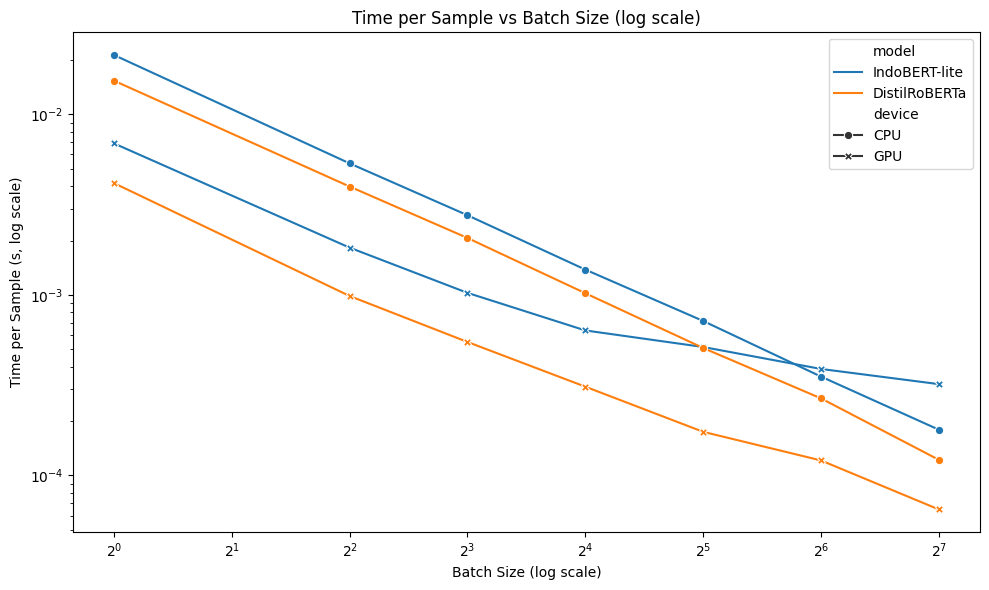

In [20]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_benchmark,
    x="batch_size",
    y="time_per_sample",
    hue="model",
    style="device",
    markers=True,
    dashes=False
)
plt.xscale('log', base=2)
plt.yscale('log')
plt.title("Time per Sample vs Batch Size (log scale)")
plt.xlabel("Batch Size (log scale)")
plt.ylabel("Time per Sample (s, log scale)")
plt.tight_layout()
plt.show()


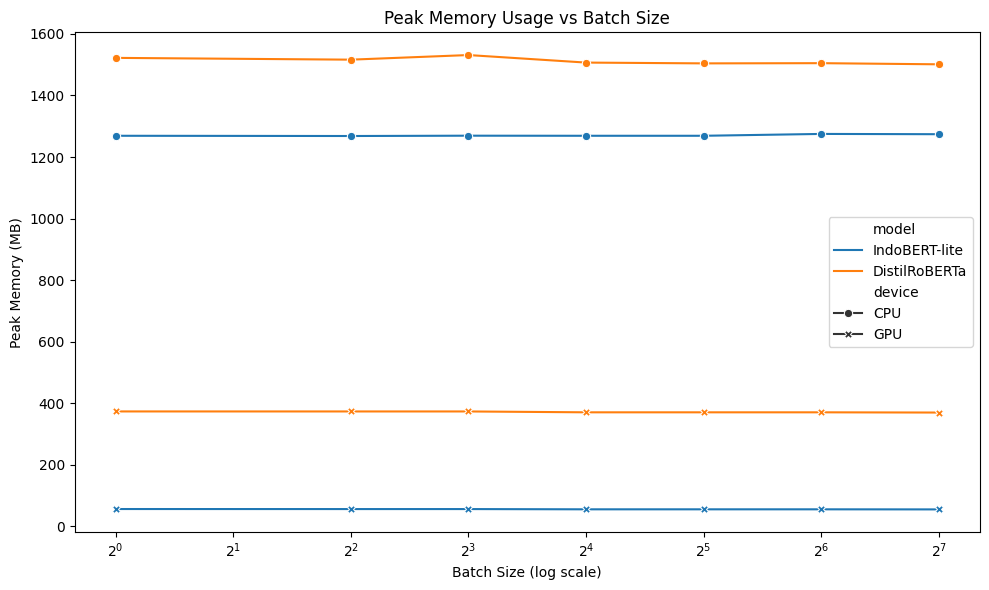

In [5]:
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=df_benchmark,
    x="batch_size",
    y="peak_mem_mb",
    hue="model",
    style="device",
    markers=True,
    dashes=False
)
plt.xscale('log', base=2)
plt.title("Peak Memory Usage vs Batch Size")
plt.xlabel("Batch Size (log scale)")
plt.ylabel("Peak Memory (MB)")
plt.tight_layout()
plt.show()


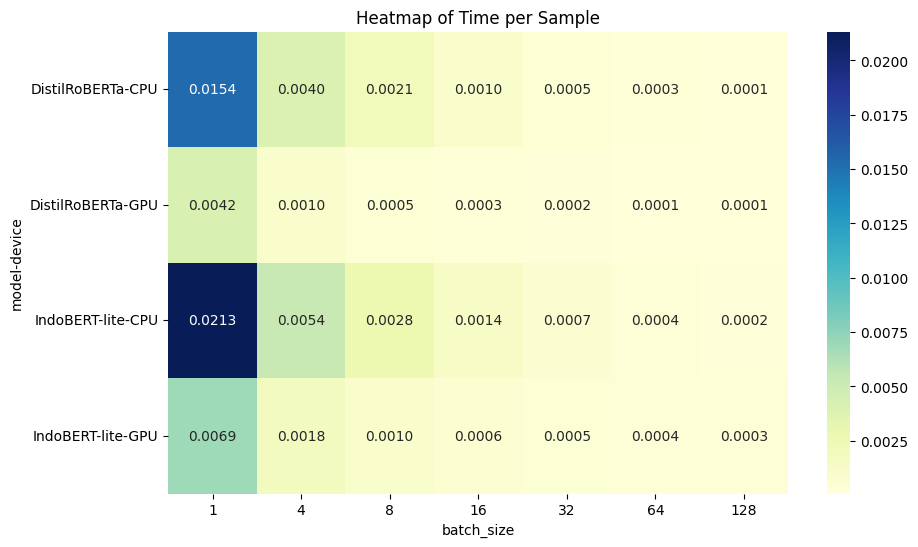

In [14]:
pivot_time = df_benchmark.pivot_table(index=['model', 'device'], columns='batch_size', values='time_per_sample')
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_time, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Heatmap of Time per Sample')
plt.show()